In [57]:
from pathlib import Path
import matplotlib.pyplot as plt
import trompy as tp
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
%matplotlib inline

In [58]:
DATAPATH = Path("C://Data//hislight_pickles//restricted_dark.pickle")

with open(DATAPATH, 'rb') as handle:
    restricted_dark = pickle.load(handle)

In [59]:
mice_to_exclude = []
#"HL202", "HL205", "HL206", "HL211" have not great placements

In [60]:
list_of_mice = []

for key, val in restricted_dark.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in list_of_mice :
            list_of_mice.append(val["mouse_ID"])

In [61]:
list_of_mice

['HL202',
 'HL203',
 'HL204',
 'HL205',
 'HL206',
 'HL207',
 'HL208',
 'HL209',
 'HL210',
 'HL211',
 'HL212']

In [62]:
restricted_dark["HL210_4"].keys()

dict_keys(['mouse_ID', 'region', 'virus', 'diet', 'total_licks', 'solution', 'corrected', 'fs', 'licks'])

In [63]:
snips_mean_start= []
snips_mean_end = []

snips_mean_full = []
run_length = []
run_licks  = []
        
kwargs={"bins":150, "trial_length":15, "baseline_length":5}   

pre = 5
post = 10
mineventlength=10
binlength=0.1

for mouse in list_of_mice:
    snips_start = []
    snips_end = []
    snips_full = []
    
    for key, val in restricted_dark.items():
        if val["mouse_ID"]==mouse:

            lickdata= tp.lickCalc(val["licks"], minrunlength=3)

            run_length.append(lickdata["rTime"])
            run_licks.append(lickdata["rLicks"])

            snips_start.append(tp.snipper(val["corrected"], lickdata["rStart"], val["fs"], **kwargs)[0])
            snips_end.append(tp.snipper(val["corrected"], lickdata["rEnd"], val["fs"], **kwargs)[0])

            snipper = tp.Snipper(val["corrected"],
                                    lickdata["rStart"],
                                    end=lickdata["rEnd"],
                                    fs=val["fs"],
                                    pre=pre,
                                    post=post,
                                    binlength=binlength,
                                    zscore=True
                                    )

            # plt.plot(snipper.snips)
            snipper.truncate_to_same_length(cols_to_add=10, mineventlength=mineventlength)
            snips_full.append(snipper.snips)
            #print(len(snipper.snips))
            #print(len(snipper.snips[0]))
            #print(len(snipper.snips[1]))


            #run_length = tp.flatten_list(run_length)
            #run_licks = tp.flatten_list(run_licks)

    snips_start = np.vstack(snips_start)
    snips_end = np.vstack(snips_end)
    snips_full = np.vstack(snips_full)

    snips_mean_start.append(np.mean(snips_start, axis=0))
    snips_mean_end.append(np.mean(snips_end, axis=0))
    snips_mean_full.append(np.mean(snips_full, axis=0))
    

    
    
snips_mean_full = np.array(snips_mean_full)


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)


In [64]:
snips_mean_full.shape

(11, 260)

<AxesSubplot:>

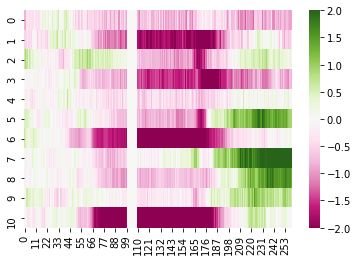

In [68]:
sns.heatmap(snips_mean_full, cmap="PiYG", vmax=2, vmin=-2)

<AxesSubplot:>

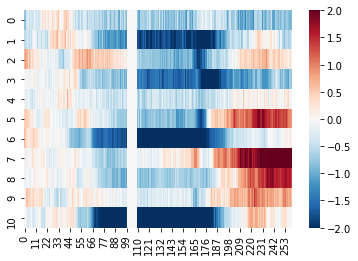

In [72]:
sns.heatmap(snips_mean_full, cmap="RdBu_r", vmax=2, vmin=-2)

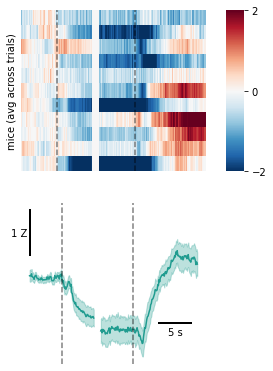

In [79]:
f,[[ax1, ax2], [ax3, ax4]]=plt.subplots(nrows=2, ncols=2,
                                        figsize=[4,6.5],
                                        gridspec_kw={"width_ratios":[10,1]})



sns.heatmap(snips_mean_full, ax=ax1, cbar_ax= ax2, cmap="RdBu_r", vmax=2, vmin=-2, cbar_kws={"ticks": [2, 0, -2]})

bins_early = int((pre + mineventlength/2)/binlength)
bins_late = int((post + mineventlength/2)/binlength)

x1 = np.arange(0,bins_early)
x2 = np.arange(snips_mean_full.shape[1] - bins_late, snips_mean_full.shape[1])

mean = np.mean(snips_mean_full, axis=0)
error_values = np.std(snips_mean_full, axis=0) / np.sqrt(len(snips_mean_full))

color="#219C90"

ax3.plot(x1, mean[:bins_early], color=color)
ax3.plot(x2, mean[-bins_late:], color=color)
ax3.fill_between(x1, mean[:bins_early]-error_values[:bins_early], mean[:bins_early]+error_values[:bins_early], color=color, alpha=0.3)
ax3.fill_between(x2, mean[-bins_late:]-error_values[-bins_late:], mean[-bins_late:]+error_values[-bins_late:], color=color, alpha=0.3)

ax4.remove()

ax1.set_yticks([])
ax1.set_xticks([])
ax1.axvline(50, color="k", linestyle="--", alpha=0.5)
ax1.axvline(160, color="k", linestyle="--", alpha=0.5)

ax3.set_yticks([])
ax3.set_xticks([])

ax1.set_ylabel("mice (avg across trials)")

for spine in ["top", "right", "left", "bottom"]:
    ax3.spines[spine].set_visible(False)

ax3.plot([200,250], [-1,-1], linewidth=2, color="k")
ax3.text(225,-1.1,"5 s", va="top", ha="center")

ax3.plot([0,0], [0.5, 1.5], linewidth=2, color="k")
ax3.text(-3, 1, "1 Z", va="center", ha="right")

ax3.axvline(50, color="k", linestyle="--", alpha=0.5)
ax3.axvline(160, color="k", linestyle="--", alpha=0.5)

f.savefig("C:\\Users\\kvo019\\OneDrive - UiT Office 365\\Pipette 2\\People\\Linnea\\Manuscripts\\hislight paper\\figures\\new_grouped.pdf")